# Post-processing for MSM

Auhors: Kazuma Iwase and Tomoyuki Takenawa

at Tokyo University of Marine Science and Technology

## Note on released code and data

This notebook is provided to publicly release the code used in our research.
However, due to data licensing restrictions, some of the distributed datasets are **not the original (real) data** and are provided as **synthetic/derived substitutes**.
Therefore, running this notebook with the shared data may **not exactly reproduce the paper results**.



### Synthetic dataset for reproducibility (Google Drive)
Data link: https://drive.google.com/drive/folders/1-fViiakeGihCxSL0KHO2n0rxnDCnVpjd?usp=sharing


This folder contains **synthetic MSM/MSMG-like** inputs regenerated by a stcastic method (not the original MSM/MSMG data), while the observation CSVs are real JMA station observations.

To fully reproduce the results, you must obtain the original data separately (under the appropriate permissions) and prepare it in the **same file/column format** expected by this notebook.
In the notebook, switch `DATA_MODE="real"` (or adjust `MSM_DIR/MSMG_DIR`) to point to your real-data folders.


> **Memory / Colab note:** This notebook can be **RAM-heavy** depending on the number of stations and lead times you load.  
> For reproducible runs, we **recommend a high-memory runtime (≈40 GB RAM or more)**.  
> On Google Colab, selecting an **A100 (High-RAM) runtime** is a convenient option.  
> (You may not actually need GPU acceleration, but the A100 runtime also provides the large-RAM environment.)



### Use the shared `data_public` via a Drive shortcut

1) Open the shared link in your browser.
   The folder will appear in Google Drive under **Shared with me**.

2) In **Shared with me**, right-click the folder **data_public** → **Organize** →
   **Add shortcut to Drive**.

3) Choose the destination folder (example):
   - **My Drive → Colab Notebooks → PostMSM**
   Then click **Add shortcut**.
   This creates a shortcut named `data_public` at:
   `/content/drive/MyDrive/PostMSM/data_public`

4) In Google Colab, mount Drive and set `ROOT` to that path:
   - `ROOT = Path("/content/drive/MyDrive/PostMSM/data_public")`

> Note: A shortcut is only a pointer. If you need an independent copy, copy the folder (of 13 GB) into **My Drive** instead of using a shortcut.




In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
from pathlib import Path

# ===== User settings =====
# "synth": use input_csv_synth / msmg_csv_synth (for the shared synthetic dataset)
# "real" : use input_csv / msmg_csv (for real data with the same column schema)
# CNN and all the saving functions are deleted or commented out in this notebook

DATA_MODE = "synth"   # <- change to "real" if you provide real data

# Project root on Google Drive (example for Colab + Drive)
PROJECT_ROOT = Path("/content/drive/MyDrive/PostMSM/")

# ===== Auto configuration =====
DATA_PUBLIC = PROJECT_ROOT / "data_public"
# RESULTS_DIR = PROJECT_ROOT / "results"
# OUTPUT_DIR  = PROJECT_ROOT / "output"

# Input directories (switch by DATA_MODE)
if DATA_MODE == "synth":
    MSM_DIR  = DATA_PUBLIC / "input_csv_synth"
    MSMG_DIR = DATA_PUBLIC / "msmg_csv_synth"
elif DATA_MODE == "real":
    MSM_DIR  = DATA_PUBLIC / "input_csv"
    MSMG_DIR = DATA_PUBLIC / "msmg_csv"
else:
    raise ValueError("DATA_MODE must be 'synth' or 'real'")

# Observation (teacher) data directory (shared for synth/real)
OBS_DIR = DATA_PUBLIC / "JMAobserve"

# # CNN (optional): if files do not exist, downstream code is designed to skip CNN comparisons
# CNN_PRED_DIR = DATA_PUBLIC / "cnn_data" / "pred"
# CNN_RESULT_CSV = RESULTS_DIR / "cnn" / "cnn_result.csv"

# # Create output folders to avoid errors when saving figures/tables
# (RESULTS_DIR / "gbm_importance_fig").mkdir(parents=True, exist_ok=True)
# (RESULTS_DIR / "selection_fig").mkdir(parents=True, exist_ok=True)
# (RESULTS_DIR / "line_fig").mkdir(parents=True, exist_ok=True)
# (RESULTS_DIR / "scatter_plot").mkdir(parents=True, exist_ok=True)
# (RESULTS_DIR / "validation_metrics_tex").mkdir(parents=True, exist_ok=True)
# (RESULTS_DIR / "test_metrics_tex").mkdir(parents=True, exist_ok=True)
# (RESULTS_DIR / "validation_metrics_fig").mkdir(parents=True, exist_ok=True)
# (RESULTS_DIR / "test_metrics_fig").mkdir(parents=True, exist_ok=True)
# (RESULTS_DIR / "wilcoxon").mkdir(parents=True, exist_ok=True)
# OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# # Quick sanity checks (paths + whether optional CNN outputs exist)
# print("DATA_MODE   =", DATA_MODE)
# print("MSM_DIR     =", MSM_DIR)
# print("MSMG_DIR    =", MSMG_DIR)
# print("OBS_DIR     =", OBS_DIR)
# print("RESULTS_DIR =", RESULTS_DIR)
# print("OUTPUT_DIR  =", OUTPUT_DIR)
# print("CNN_PRED_DIR exists?   ", CNN_PRED_DIR.exists())
# print("CNN_RESULT_CSV exists? ", CNN_RESULT_CSV.exists())


In [3]:
!pip install --upgrade scikit-learn
!pip install optuna-integration

In [4]:
from optuna_integration.lightgbm import LightGBMTuner
import optuna

import datetime
import pandas as pd
import numpy as np
import cupy as cp
import os, time
import json
import glob, re
import calendar
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.model_selection import train_test_split
import sklearn
from scipy.stats import ttest_rel
import tensorflow as tf
import lightgbm as lgb
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold, SelectKBest, r_regression, mutual_info_regression
import dask.bag as db
import matplotlib.dates as mdates
import matplotlib.dates as dates
import seaborn as sns
sns.set()

SEED=1
tf.keras.utils.set_random_seed(1)
tf.config.experimental.enable_op_determinism()

## Functions

In [5]:

def split_data(h, hdf, outputdf):
    # Split by fixed date ranges; note the "+h hours" shift to align each lead time.
    train_start = datetime.datetime(year=2019, month=1, day=1, hour=0) + datetime.timedelta(hours=h)
    train_end = datetime.datetime(year=2022, month=1, day=1, hour=0)
    validation_start = datetime.datetime(year=2022, month=1, day=1, hour=0) + datetime.timedelta(hours=h)
    validation_end = datetime.datetime(year=2023, month=1, day=1, hour=0)
    test_start = datetime.datetime(year=2023, month=1, day=1, hour=0) + datetime.timedelta(hours=h)
    test_end = datetime.datetime(year=2023, month=12, day=31, hour=21) + datetime.timedelta(hours=h)

    train_df = hdf.loc[train_start:train_end]
    validation_df = hdf.loc[validation_start:validation_end]
    test_df = hdf.loc[test_start:test_end]

    # Attach observation (teacher) columns by timestamp index (must be aligned).
    train_df = pd.concat([train_df, outputdf.loc[train_df.index]], axis=1)
    validation_df = pd.concat([validation_df, outputdf.loc[validation_df.index]], axis=1)
    test_df = pd.concat([test_df, outputdf.loc[test_df.index]], axis=1)

    return train_df, validation_df, test_df


def read_and_process_csv(pos, h, outputdf):
    # Select MSM file depending on DATA_MODE ("synth" vs "real").
    fname = f"all_msm_synth_{pos}_{h}h.csv" if DATA_MODE=="synth" else f"all_msm_{pos}_{h}h.csv"
    hdf = pd.read_csv(MSM_DIR / pos / fname, index_col=0)
    hdf.index = pd.to_datetime(hdf.index)

    # Add time features that are always kept as baseline inputs.
    hdf.insert(0, 'predict_hour', np.full(len(hdf), h))
    hdf.insert(1, 'hour', hdf.index.hour)
    hdf.insert(2, 'month', hdf.index.month)

    train_df, validation_df, test_df = split_data(h, hdf, outputdf)
    return train_df, validation_df, test_df


def get_train_validation_test_by_db(pos, timelist):
    # Read observation (teacher) data once, then merge into each lead-time MSM table.
    outputdf = pd.read_csv(OBS_DIR / pos / f"all_jma_{pos}.csv", index_col=0)
    outputdf.index = pd.to_datetime(outputdf.index)

    # Parallelize per-lead-time CSV reading using dask.bag (db).
    bag = db.from_sequence(timelist)
    results = bag.map(lambda h: read_and_process_csv(pos, h, outputdf)).compute()

    train_combined_df_tuple, validation_combined_df_tuple, test_combined_df_tuple = zip(*results)
    train_combined_df = pd.concat(train_combined_df_tuple, axis=0)
    validation_combined_df = pd.concat(validation_combined_df_tuple, axis=0)

    # Keep test as a list of DataFrames (one per lead time) for later per-lead evaluation.
    test_hlist = list(test_combined_df_tuple)
    return train_combined_df, validation_combined_df, test_hlist


def read_msmg(pos, h):
    # Read MSMG baseline (post-processed forecast) for a given lead time.
    hfname = f"all_msmg_synth_{pos}_{h}h.csv" if DATA_MODE=="synth" else f"all_msmg_{pos}_{h}h.csv"
    hdf = pd.read_csv(MSMG_DIR / pos / hfname, index_col=0)
    hdf.index = pd.to_datetime(hdf.index)
    return hdf


def feature_selection_cupy(df, threshold=0.8):
    # Drop always-removed "center-grid" t-lags and static p-features before correlation-based pruning.
    columns = df.filter(regex=f'(0_0_t-0|0_0_t-1|0_0_t-2|0_0_p)').columns.tolist()
    columns += ['predict_hour', 'hour', 'month']
    df = df.drop(columns=columns)

    # Compute absolute correlation matrix on GPU (CuPy) and drop highly-correlated features.
    correlation_matrix = cp.corrcoef(cp.asarray(df.values), rowvar=False)
    correlation_matrix = cp.absolute(correlation_matrix)
    upper_cpu = cp.asnumpy(cp.where(cp.triu(cp.ones(correlation_matrix.shape), k=1).astype(bool), correlation_matrix, 0))
    drop_features = [column for column in df.columns if any(upper_cpu[:, df.columns.get_loc(column)] > threshold)]
    return drop_features


def select_features_r_regression(x_train, y_train, k):
    # Feature selection by Pearson correlation (r_regression), keeping time features.
    x_train_drop = x_train.drop(columns=['predict_hour', 'hour', 'month'])
    correlations = r_regression(x_train_drop, y_train)
    top_k3_idx = np.abs(correlations).argsort()[::-1][:k-3]
    selected_features = ['predict_hour', 'hour', 'month'] + x_train_drop.columns[top_k3_idx].tolist()
    x_train_new = x_train.loc[:, selected_features]
    return x_train_new, selected_features


def select_features_mutual_info(x_train, y_train, k):
    # Feature selection by mutual information, keeping time features.
    x_train_drop = x_train.drop(columns=['predict_hour', 'hour', 'month'])
    mutual_info = mutual_info_regression(x_train_drop, y_train, random_state=SEED, n_jobs=-1)
    top_k3_idx = mutual_info.argsort()[::-1][:k-3]
    selected_features = ['predict_hour', 'hour', 'month'] + x_train_drop.columns[top_k3_idx].tolist()
    x_train_new = x_train.loc[:, selected_features]
    return x_train_new, selected_features


def select_features_gbm(x_train, y_train, x_validation, y_validation, k, fig_gain=False, pos=None, c=None, num=15):
    # Feature selection by LightGBM gain importance; optional importance plot saved to RESULTS_DIR.
    gbm = train_lgbm(x_train, y_train, x_validation, y_validation)
    importance = gbm.feature_importance(importance_type='gain')
    top_idx = importance.argsort()[::-1]
    selected_features = ['predict_hour', 'hour', 'month']
    for idx in top_idx:
        feature = x_train.columns[idx]
        if feature not in selected_features:
            selected_features.append(feature)
        if len(selected_features) == k:
            break

    x_train_new = x_train.loc[:, selected_features]

    if fig_gain:
        fig, ax = plt.subplots(figsize=(6, 6))
        ax.barh(x_train.columns[top_idx[:num]], importance[top_idx[:num]])
        ax.set_title(f'{c} {pos}')
        fig.tight_layout()
        # fig.savefig(RESULTS_DIR / "gbm_importance_fig" / f"gbm_importance_{c}_{pos}.png")
        plt.close(fig)

    return x_train_new, selected_features


def get_y_msm_and_msmg(y_all, mask, outc, df, msmg_df=None):
    # Build baseline outputs from MSM features (tp reconstructed from 3-hour accumulations).
    y_msm = np.full((len(y_all), len(outc)), np.nan)
    pattern = [f'{c}_0_0_t-0' for c in outc if c != 'tp']
    pattern_tp = [f'tp_0_0_t-{t}' for t in range(0, 3)]

    df = df[mask]
    filtered_df = df[pattern]
    filtered_df_tp = df[pattern_tp].sum(axis=1)
    filtered_df_tp = pd.DataFrame(filtered_df_tp, columns=['tp'])
    filtered_df = pd.concat([filtered_df_tp, filtered_df], axis=1)
    y_msm[mask] = filtered_df.values

    # If MSMG is provided, align by the same timestamp index.
    if msmg_df is not None:
        y_msmg = np.full((len(y_all), len(outc)), np.nan)
        filtered_msmg_df = msmg_df.loc[filtered_df.index]
        y_msmg[mask] = filtered_msmg_df.values
        return y_msm, y_msmg
    else:
        return y_msm


def compute_ypred(y_all, predictions, mask, outcolumns):
    # Map predictions back to the full timeline and apply precipitation rounding (<0.25mm -> 0).
    y_pred = np.full((len(y_all), len(outcolumns)), np.nan)
    y_pred[mask] = predictions
    y_pred[:,0][y_pred[:,0] < 0.25] = 0
    return y_pred


def compute_ytrue(y_all, mask):
    # Keep y_true as DataFrame for later index-based slicing/plotting.
    y_true = y_all.copy()
    y_true.iloc[~mask, :] = np.nan
    return y_true


def feature_filter(w, s, p, df):
    # Select features by (time lags w) and (spatial window s,p) via regex.
    ws_pattern = '|'.join([f'{i}_{j}_t-{l}' for i in range(-s, s + 1) for j in range(-s, s + 1) for l in range(w + 1)])
    p_pattern = '|'.join([f'{i}_{j}_p' for i in range(-p, p + 1) for j in range(-p, p + 1)])
    combined_pattern = f'{ws_pattern}|{p_pattern}|predict_hour|hour|month'
    filtered_df = df.filter(regex=combined_pattern)
    return filtered_df


def get_xy_train_validation_test(outcolumns, train_combined_df, validation_combined_df, test_list, grids):
    # Define the feature window: 'around' uses larger spatial context + correlation pruning.
    if grids == '1grid':
        w, s, p = 2, 0, 0
    elif grids == 'around':
        w, s, p = 2, 5, 3

    train_combined_df = train_combined_df.dropna(subset=outcolumns)
    validation_mask = ~validation_combined_df[outcolumns].isna().any(axis=1)
    x_train, y_train = train_combined_df.drop(columns=outcolumns), train_combined_df[outcolumns]
    x_validation_all, y_validation_all = validation_combined_df.drop(columns=outcolumns), validation_combined_df[outcolumns]
    x_train = feature_filter(w, s, p, x_train)
    feature_nums = x_train.shape[1]

    if grids == 'around':
        drop_features = feature_selection_cupy(x_train, threshold=0.9)
        x_train = x_train.drop(columns=drop_features)

    drop_feature_nums = x_train.shape[1]
    x_validation_all = x_validation_all[x_train.columns]

    # Keep test per-lead DataFrame; masks handle missing observations.
    x_test_all_list = []; y_test_all_list = []; test_mask_list = []
    for i, h in enumerate(test_list):
        test_df = test_list[i]
        test_mask = ~test_df[outcolumns].isna().any(axis=1)
        x_test_all, y_test_all = test_df.drop(columns=outcolumns), test_df[outcolumns]
        x_test_all = x_test_all[x_train.columns]
        x_test_all_list.append(x_test_all); y_test_all_list.append(y_test_all); test_mask_list.append(test_mask)

    return {'x_train': x_train, 'y_train': y_train, 'x_validation_all': x_validation_all, 'y_validation_all': y_validation_all,
            'validation_mask': validation_mask, 'x_test_all_list': x_test_all_list, 'y_test_all_list': y_test_all_list,
            'test_mask_list': test_mask_list, 'feature_nums': feature_nums, 'drop_feature_nums': drop_feature_nums}


def compute_selected_features(x_train, y_train, x_validation, y_validation, outcolumns, fselect, c, k, fig_gain=False, pos=None):
    # Wrapper for per-target feature selection strategies.
    if fselect =='pcc':
        x_train_selected, selected_features = select_features_r_regression(x_train, y_train[c], k)
        x_validation_selected = x_validation.loc[:, selected_features]
    elif fselect == 'mi':
        x_train_selected, selected_features = select_features_mutual_info(x_train, y_train[c], k)
        x_validation_selected = x_validation.loc[:, selected_features]
    elif fselect == 'gbm':
        x_train_selected, selected_features = select_features_gbm(x_train, y_train[c], x_validation, y_validation[c], k,
                                                                  fig_gain=fig_gain, pos=pos, c=c)
        x_validation_selected = x_validation.loc[:, selected_features]
    return x_train_selected, x_validation_selected, selected_features


def train_and_validation(x_train, y_train, x_validation_all, y_validation_all, validation_mask, outcolumns, tune=False,
                         params=None, fselect=None, klist=None, fig_gain=False, pos=None):
    # Train either a single NN or 3 independent GBMs (one per output variable).
    predictions = []; best_params_list = []; model_list = []; selected_features_list = []
    x_validation = x_validation_all[validation_mask]
    y_validation = y_validation_all[validation_mask]

    if fselect == 'nn':
        model = train_nn(x_train, y_train, x_validation, y_validation)
        model_list.append(model)
        predictions = model.predict(x_validation, verbose=0)
    else:
        for i, c in enumerate(outcolumns):
            if fselect in ['pcc', 'mi', 'gbm']:
                k = klist[i]
                x_train_selected, x_validation_selected, selected_features = compute_selected_features(x_train, y_train, x_validation, y_validation,
                                                                                                    outcolumns, fselect, c, k, fig_gain=fig_gain, pos=pos)
                selected_features_list.append(selected_features)
            else:
                x_train_selected, x_validation_selected = x_train, x_validation

            if tune:
                model, best_params = train_lgbm(x_train_selected, y_train[c], x_validation_selected, y_validation[c], tune=True)
                best_params_list.append(best_params)
            else:
                if params == None:
                    model = train_lgbm(x_train_selected, y_train[c], x_validation_selected, y_validation[c])
                else:
                    model = train_lgbm(x_train_selected, y_train[c], x_validation_selected, y_validation[c], params=params[i])
                model_list.append(model)

            predictions.append(model.predict(x_validation_selected))

        predictions = np.array(predictions).T

    y_pred = compute_ypred(y_validation_all, predictions, validation_mask, outcolumns)
    return {'y_pred': y_pred, 'best_params_list': best_params_list, 'selected_features_list': selected_features_list,
            'model_list': model_list}


def train_lgbm(x_train, y_train, x_validation, y_validation, num_boost_round=10000, patience=10,
               verbose=False, tune=False, params=None, pos=None):
    # LightGBM training with early stopping; optional Optuna tuning via LightGBMTuner.
    lgb_train = lgb.Dataset(x_train, y_train)
    lgb_eval = lgb.Dataset(x_validation, y_validation)

    if params == None:
        params = {
            'boosting_type': 'gbdt',
            'objective': 'regression',
            'metric': 'rmse',
            'verbose': -1,
            'num_threads': -1,
            'seed': SEED
        }

    if tune:
        tuner = LightGBMTuner(params, lgb_train, num_boost_round=num_boost_round, valid_sets=lgb_eval, optuna_seed=0,
                              callbacks=[lgb.early_stopping(stopping_rounds=patience, verbose=verbose)], show_progress_bar=True)
        optuna.logging.set_verbosity(1)
        tuner.run()
        best_params = tuner.best_params
        print(best_params)
        gbm = tuner.get_best_booster()
        return gbm, best_params
    else:
        gbm = lgb.train(params,
                        lgb_train,
                        num_boost_round=num_boost_round,
                        valid_sets=lgb_eval,
                        callbacks=[lgb.early_stopping(stopping_rounds=patience, verbose=verbose)])
        return gbm


def train_nn(x_train, y_train, x_validation=False, y_validation=False, epochs=1000, batch_size=64, learning_rate=0.001, patience=10):
    # Simple MLP baseline (3 outputs); early stopping monitors validation RMSE.
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(1000, activation='relu'),
        tf.keras.layers.Dense(500, activation='relu'),
        tf.keras.layers.Dense(100, activation='relu'),
        tf.keras.layers.Dense(3)
    ])

    model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  metrics=[tf.keras.metrics.RootMeanSquaredError(name='RMSE')])
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_RMSE', patience=patience)

    history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=0, validation_data=(x_validation, y_validation),
                        callbacks=[early_stopping])
    plot_nn_loss(history)
    return model


def plot_nn_loss(history):
    # Plot training/validation loss curves for debugging.
    loss=history.history['loss']
    val_loss=history.history['val_loss']
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    ax.plot(np.arange(len(loss)), loss, label='Training loss')
    ax.plot(np.arange(len(val_loss)), val_loss, label='Validation loss')
    ax.legend()
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.grid(True)
    plt.show()
    plt.close(fig)


def compare_selction_k(x_train, y_train, x_validation_all, y_validation_all, validation_mask, outcolumns, grids):
    # Sweep k (number of selected features) to find the best per-variable RMSE.
    select_dict = {}
    x_validation = x_validation_all[validation_mask]
    y_validation = y_validation_all[validation_mask]
    for fselect in ['pcc', 'mi', 'gbm']:
        if grids == '1grid':
            klist = [i for i in range(10, 60, 10)] + [59]
        elif grids == 'around':
            klist = [i for i in range(10, 210, 10)]

        c_selected_features_list = []
        for i, c in enumerate(outcolumns):
            _, _, selected_features = compute_selected_features(x_train, y_train, x_validation, y_validation,
                                                                outcolumns, fselect, c, k=np.max(klist)+1)
            c_selected_features_list.append(selected_features)

        y_val_true = compute_ytrue(y_validation_all, validation_mask)
        rmse_list = []
        for k in klist:
            predictions = []
            for i, c in enumerate(outcolumns):
                selected_features = c_selected_features_list[i]
                x_train_k = x_train.loc[:, selected_features[:k]]
                x_validation_k = x_validation.loc[:, selected_features[:k]]
                model = train_lgbm(x_train_k, y_train[c], x_validation_k, y_validation[c])
                predictions.append(model.predict(x_validation_k))

            y_val_pred = compute_ypred(y_validation_all, np.array(predictions).T, validation_mask, outcolumns)
            rmse = np.sqrt(np.nanmean((y_val_true - y_val_pred)**2, axis=0))
            rmse_list.append(rmse)

        rmse_array = np.array(rmse_list)
        optk = [klist[i] for i in np.argmin(rmse_array, axis=0)]
        select_dict[fselect] = (optk, rmse_array, klist)
    return select_dict


def plot_selection(selection_dict):
    # Plot RMSE vs k for each selection method and grid setting.
    fig0, ax0 = plt.subplots(1, 1, figsize=(10, 5))
    fig1, ax1 = plt.subplots(1, 1, figsize=(10, 5))
    fig2, ax2 = plt.subplots(1, 1, figsize=(10, 5))
    color_dict = {'1grid': sns.color_palette()[3], 'around': sns.color_palette()[4]}
    marker_dict = {'pcc': 'D', 'mi': 'o', 'gbm': 's'}

    ordinal_dict = {1: '1st', 2: '2nd', 3: '3rd', 4: '4th', 5: '5th', 6: '6th'}

    rank_dict = {}
    for i, c in enumerate(['Precipitation', 'Temperature', 'Wind Speed']):
        rmse_list = []
        for grids in ['1grid', 'around']:
            for fselect in ['pcc', 'mi', 'gbm']:
                optk, rmse_array, klist = selection_dict[grids][fselect]
                rmse_list.append(np.min(rmse_array[:,i]))
        rmse_array = np.array(rmse_list)
        rank_indices = np.argsort(rmse_array)
        rank = np.empty_like(rank_indices)
        rank[rank_indices] = np.arange(len(rank_indices)) + 1
        ordinal_ranks = [ordinal_dict[r] for r in rank]
        rank_dict[c] = ordinal_ranks

    count = 0
    for grids in ['1grid', 'around']:
        for fselect in ['pcc', 'mi', 'gbm']:
            optk, rmse_array, klist = selection_dict[grids][fselect]
            ax0.plot(klist, rmse_array[:,0], label=f'{grids} {fselect} ({rank_dict["Precipitation"][count]})',
                     color=color_dict[grids], marker=marker_dict[fselect])
            ax1.plot(klist, rmse_array[:,1], label=f'{grids} {fselect} ({rank_dict["Temperature"][count]})',
                     color=color_dict[grids], marker=marker_dict[fselect])
            ax2.plot(klist, rmse_array[:,2], label=f'{grids} {fselect} ({rank_dict["Wind Speed"][count]})',
                     color=color_dict[grids], marker=marker_dict[fselect])
            count += 1
    ax0.legend(); ax1.legend(); ax2.legend(); ax0.set_ylabel('RMSE'); ax1.set_ylabel('RMSE'); ax2.set_ylabel('RMSE')
    ax0.set_xlabel('k'); ax1.set_xlabel('k'); ax2.set_xlabel('k')
    ax0.set_title('Precipitation'); ax1.set_title('Temperature'); ax2.set_title('Wind Speed')
    fig0.tight_layout(); fig1.tight_layout(); fig2.tight_layout()
    # fig0.savefig(RESULTS_DIR / "selection_fig" / "selection_precipitation.png")
    # fig1.savefig(RESULTS_DIR / "selection_fig" / "selection_temperature.png")
    # fig2.savefig(RESULTS_DIR / "selection_fig" / "selection_windspeed.png")


import os
import numpy as np
import pandas as pd
from scipy.stats import ttest_rel

def get_cnn_perd(position_df, phase="test", pred_dir=None, strict=False):
    # Optional baseline: if CNN prediction files are missing, return None and skip.
    if pred_dir is None:
        pred_dir = DATA_PUBLIC / "cnn_data" / "pred"
    else:
        pred_dir = Path(pred_dir)

    test_pred_list = []
    for pos in position_df.index:
        fp = pred_dir / f"{pos}_{phase}.npz"
        if not fp.exists():
            if strict:
                raise FileNotFoundError(str(fp))
            print(f"[WARN] CNN pred not found -> skip CNN: {fp}")
            return None

        data = np.load(fp)
        if "test_pred" in data:
            test_pred_list.append(data["test_pred"])
        elif "pred" in data:
            test_pred_list.append(data["pred"])
        else:
            if strict:
                raise KeyError(f"'test_pred' (or 'pred') not found in {fp}: keys={list(data.keys())}")
            print(f"[WARN] CNN npz has no 'test_pred'/'pred' -> skip CNN: {fp}")
            return None

    test_cnn_pred_array = np.concatenate(test_pred_list, axis=0)
    return test_cnn_pred_array



def comute_wilcoxon(position_df, pred_list, nn_list, msm_list, true_list, msmg_list,
                    use_cnn=True, cnn_phase="test", cnn_pred_dir=None):
    # Despite the name, this function performs paired t-tests (one-sided, "less") on absolute errors.
    pred_array = np.array(pred_list)
    msm_array  = np.array(msm_list)
    true_array = np.array(true_list)
    msmg_array = np.array(msmg_list)

    pred_diff = np.abs((pred_array - true_array).reshape(-1, 3))
    pred_diff = pred_diff[~np.isnan(pred_diff).any(axis=1), :]

    msm_diff = np.abs((msm_array - true_array).reshape(-1, 3))
    msm_diff = msm_diff[~np.isnan(msm_diff).any(axis=1), :]

    msmg_diff = np.abs((msmg_array - true_array).reshape(-1, 3))
    msmg_diff = msmg_diff[~np.isnan(msmg_diff).any(axis=1), :]

    diff_list = [msm_diff, msmg_diff]
    index = ["MSM", "MSMG"]

    if nn_list is not None:
        nn_array = np.array(nn_list)
        nn_diff = np.abs((nn_array - true_array).reshape(-1, 3))
        nn_diff = nn_diff[~np.isnan(nn_diff).any(axis=1), :]
        diff_list.append(nn_diff)
        index.append("NN")

    res = {}
    for i, c in enumerate(["Precipitation", "Temperature", "Wind Speed"]):
        res[c] = []
        for diff in diff_list:
            _, p_value = ttest_rel(pred_diff[:, i], diff[:, i], alternative="less")
            res[c].append(p_value)

    res_table = pd.DataFrame(res, index=index)

    if use_cnn:
        test_cnn_pred_array = get_cnn_perd(position_df, phase=cnn_phase, pred_dir=cnn_pred_dir, strict=False)
        if test_cnn_pred_array is not None:
            true_temp = true_array[:, :, :, 1].flatten()
            true_temp = true_temp[~np.isnan(true_temp)]
            n = min(len(test_cnn_pred_array), len(true_temp))
            cnn_diff = np.abs(test_cnn_pred_array[:n] - true_temp[:n])
            _, p_cnn = ttest_rel(pred_diff[:n, 1], cnn_diff, alternative="less")
            res_table.loc["CNN", :] = ["", p_cnn, ""]
        else:
            res_table.loc["CNN", :] = ["", "", ""]

    display(res_table)

    # out_tex = RESULTS_DIR / "wilcoxon.tex"
    # out_tex.parent.mkdir(parents=True, exist_ok=True)
    # with open(out_tex, "w") as file:
    #     file.write(res_table.to_latex(column_format="l|rrr", float_format="%.3g"))

    return res_table




def get_metrics_errors(pred_list, msm_list, true_list, phase=False, pt=False, msmg_list=None):
    # Compute RMSE and mean error (ME) for baselines and prediction, aggregated by pt (overall/position/time).
    pred_array = np.array(pred_list)
    msm_array = np.array(msm_list)
    true_array = np.array(true_list)

    pred_diff = pred_array - true_array
    msm_diff = msm_array - true_array

    if phase == 'test':
        msmg_array = np.array(msmg_list)
        msmg_diff = msmg_array - true_array
        if pt == 'position':
            axis1, axis2 = (1, 2), 1
        elif pt == 'time':
            axis1, axis2 = (0, 2), 1
        else:
            axis1, axis2 = (1, 2, 3), 0
            msm_diff = msm_diff[np.newaxis, :, :, :, :]
            msmg_diff = msmg_diff[np.newaxis, :, :, :, :]

        error_metrics = np.concatenate((np.nanmean(msm_diff, axis=axis1), np.nanmean(msmg_diff, axis=axis1), np.nanmean(pred_diff, axis=axis1)),
                                       axis=axis2).reshape(-1,3)
        rmse_metrics = np.concatenate((np.sqrt(np.nanmean(msm_diff**2, axis=axis1)), np.sqrt(np.nanmean(msmg_diff**2, axis=axis1)),
                                       np.sqrt(np.nanmean(pred_diff**2, axis=axis1))), axis=axis2).reshape(-1,3)
    else:
        axis1, axis2 = (1, 2), 0
        msm_diff = msm_diff[np.newaxis, :, :, :]
        error_metrics = np.concatenate((np.nanmean(msm_diff, axis=axis1), np.nanmean(pred_diff, axis=axis1)), axis=axis2)
        rmse_metrics = np.concatenate((np.sqrt(np.nanmean(msm_diff**2, axis=axis1)), np.sqrt(np.nanmean(pred_diff**2, axis=axis1))),
                                      axis=axis2)
    metrics_array = np.concatenate((rmse_metrics, error_metrics), axis=1)
    return metrics_array


def get_ctuples(items):
    # Helper for MultiIndex columns: (metric, variable).
    ctuples = []
    for i in items:
        ctuples.append((i, 'Precipitation')); ctuples.append((i, 'Temperature')); ctuples.append((i, 'Wind Speed'))
    return ctuples


def get_ituples(items):
    # Helper for MultiIndex index: (point, model).
    ituples = []
    for i in items:
        ituples.append((i, 'MSM')); ituples.append((i, 'MSMG')); ituples.append((i, 'Prediction'))
    return ituples


def comute_accuracy_overall(pred_list, msm_list, true_list, phase, model_names=None, msmg_list=None):
    # Generate LaTeX tables for overall RMSE/ME; CNN row is added only if the csv exists.
    metrics_array = get_metrics_errors(pred_list, msm_list, true_list, phase=phase, pt=False, msmg_list=msmg_list)

    ctuples = get_ctuples(['RMSE', 'ME'])
    columns = pd.MultiIndex.from_tuples(ctuples)
    index = [mname.replace('_', ' ') for mname in model_names]
    metrics_df = pd.DataFrame(metrics_array, columns=columns, index=index)

    # cnn_csv = RESULTS_DIR / "cnn" / "cnn_result.csv"
    # if cnn_csv.exists():
    #     cnn_df = pd.read_csv(cnn_csv, index_col=0)

    #     # Keep float dtype: use NaN instead of '' for non-temperature cells
    #     row = [np.nan, np.nan, np.nan, np.nan, np.nan, np.nan]

    #     if phase == 'validation':
    #         row[1] = float(cnn_df['persample_val_pred_rmse'].values[0])  # Temperature RMSE
    #         row[4] = float(cnn_df['persample_val_pred_me'].values[0])    # Temperature ME
    #     elif phase == 'test':
    #         row[1] = float(cnn_df['persample_test_pred_rmse'].values[0]) # Temperature RMSE
    #         row[4] = float(cnn_df['persample_test_pred_me'].values[0])   # Temperature ME
    #     metrics_df.loc['CNN', :] = row
    display(metrics_df.round(3))

    # out_dir = RESULTS_DIR / f"{phase}_metrics_tex"
    # out_dir.mkdir(parents=True, exist_ok=True)
    # out_tex = out_dir / f"{phase}_overall_metrics.tex"
    # with open(out_tex, 'w') as file:
    #     file.write(metrics_df.to_latex(column_format='l|rrr|rrr', multicolumn=True, multicolumn_format='c', float_format='%.3f'))


def plot_metrics_line(df, i, j, phase, ptlist, pt):
    # Save line plots for RMSE/ME by position/time.
    pred = df.loc[pd.IndexSlice[:, 'Prediction'], pd.IndexSlice[i, j]]
    msm = df.loc[pd.IndexSlice[:, 'MSM'], pd.IndexSlice[i, j]]
    msmg = df.loc[pd.IndexSlice[:, 'MSMG'], pd.IndexSlice[i, j]]

    fig, ax = plt.subplots(1, 1, figsize=(10, 4))
    ax.plot(range(len(pred)), pred, label='Prediction', marker='o')
    ax.plot(range(len(msm)), msm, label='MSM', marker='o')
    ax.plot(range(len(msmg)), msmg, label='MSMG', marker='o')
    ax.legend()
    ax.set_title(f'{i} {j}')
    if pt == 'position':
        ax.set_xticks(range(len(ptlist)), ptlist, rotation=45)
    elif pt == 'time':
        ax.set_xticks(range(len(pred)), ptlist)
    ax.set_ylabel(i)
    fig.tight_layout()

    # out_dir = RESULTS_DIR / f"{phase}_metrics_fig"
    # out_dir.mkdir(parents=True, exist_ok=True)
    # fig.savefig(out_dir / f"{phase}_{pt}_line_{i}_{j}.png")


def comute_accuracy_pt(ptlist, pred_list, msm_list, true_list, phase, pt=False, msmg_list=None):
    # Per-position or per-time metrics tables + plots.
    metrics_array = get_metrics_errors(pred_list, msm_list, true_list, phase=phase, pt=pt, msmg_list=msmg_list)

    ctuples = get_ctuples(['RMSE', 'ME'])
    if pt == 'position':
        ituples = get_ituples(ptlist)
    elif pt == 'time':
        ituples = get_ituples(ptlist)

    columns = pd.MultiIndex.from_tuples(ctuples)
    index = pd.MultiIndex.from_tuples(ituples)
    metrics_df = pd.DataFrame(metrics_array, columns=columns, index=index)
    display(metrics_df.round(3))

    # out_dir = RESULTS_DIR / f"{phase}_metrics_tex"
    # out_dir.mkdir(parents=True, exist_ok=True)
    # with open(out_dir / f"{phase}_{pt}_metrics.tex", 'w') as file:
    #     file.write(metrics_df.to_latex(column_format='l|l|rrr|rrr', multicolumn=True, multicolumn_format='c', multirow=True, float_format='%.3f'))

    for i in ['RMSE', 'ME']:
        for j in outcolumns:
            plot_metrics_line(metrics_df, i, j, phase, ptlist, pt)


def base_line_plot(pos, h, y_pred, y_msm, y_msmg, y_true, lm, um):
    # Plot time-series and scatter comparisons for a selected month range (lm..um).
    y_pred = pd.DataFrame(y_pred, index=y_true.index, columns=y_true.columns)
    y_msm = pd.DataFrame(y_msm, index=y_true.index, columns=y_true.columns)
    y_msmg = pd.DataFrame(y_msmg, index=y_true.index, columns=y_true.columns)
    y_mask = (y_true.index.month >= lm) & (y_true.index.month <= um)
    y_pred = y_pred[y_mask]; y_msm = y_msm[y_mask]; y_msmg = y_msmg[y_mask]; y_true = y_true[y_mask]

    # line_dir = RESULTS_DIR / "line_fig"
    # scat_dir = RESULTS_DIR / "scatter_plot"
    # line_dir.mkdir(parents=True, exist_ok=True)
    # scat_dir.mkdir(parents=True, exist_ok=True)

    for l, c in enumerate(['Precipitation', 'Temperature', 'Wind Speed']):
        fig, ax = plt.subplots(1, 1, figsize=(12, 5))
        ax.plot(y_true.loc[:, c], label='Observation')
        ax.plot(y_msm.loc[:, c], label='MSM')
        ax.plot(y_msmg.loc[:, c], label='MSMG')
        ax.plot(y_pred.loc[:, c], label='Prediction')
        ax.legend()
        ax.set_title(f'{pos} {h}h {c}')
        ax.set_ylabel(c)
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
        plt.xticks(rotation=45)
        fig.tight_layout()
        # fig.savefig(line_dir / f"{pos}_{h}h_{c}.png")
        plt.show()
        plt.close(fig)

        fig, ax = plt.subplots(1, 1, figsize=(6, 6))
        ax.plot(y_true.loc[:, c], y_true.loc[:, c], c='black', alpha=0.5)
        ax.scatter(y_true.loc[:, c], y_pred.loc[:, c], label='Prediction', marker='o', s=5)
        ax.scatter(y_true.loc[:, c], y_msm.loc[:, c], label='MSM', marker='o', s=5)
        ax.legend()
        ax.set_xlabel('Observation')
        ax.set_ylabel('Prediction or MSM')
        ax.set_title(f'{pos} {h}h {c}')
        fig.tight_layout()
        # fig.savefig(scat_dir / f"{pos}_{h}h_{c}.png")
        plt.show()
        plt.close(fig)


def plot_scatter_fig(pred_list, msm_list, true_list):
    # Global scatter plots (all samples merged).
    pred_array = np.array(pred_list).reshape(-1,3)
    msm_array = np.array(msm_list).reshape(-1,3)
    true_array = np.array(true_list).reshape(-1,3)

    # out_dir = RESULTS_DIR / "scatter_plot"
    # out_dir.mkdir(parents=True, exist_ok=True)

    for i, c in enumerate(['Precipitation', 'Temperature', 'Wind Speed']):
        fig, ax = plt.subplots(1, 1, figsize=(6, 6))
        ax.plot(true_array[:,i], true_array[:,i])
        ax.scatter(true_array[:,i], pred_array[:,i], label='Prediction', marker='o', s=3, alpha=0.5)
        ax.scatter(true_array[:,i], msm_array[:,i], label='MSM', marker='o', s=3, alpha=0.5)
        ax.legend()
        ax.set_xlabel('Observation')
        ax.set_ylabel('Prediction or MSM')
        ax.set_title(c)
        fig.tight_layout()
        # fig.savefig(out_dir / f"scatter_plot_{c}.png")
        plt.show()
        plt.close(fig)



def plot_line_fig(position_df, timelist, pred_list, msm_ylist, msmg_ylist, true_list, pos_lmu_dict):
    # Convenience wrapper: only plot selected lead times (3/18/39h) and selected sites in pos_lmu_dict.
    for i, pos in enumerate(position_df.index):
        for j, h in enumerate(timelist):
            if (h==3 or h==18 or h==39) and pos in [p for p in pos_lmu_dict.keys()]:
                y_pred = pred_list[i][j]; y_msm = msm_ylist[i][j]; y_msmg = msmg_ylist[i][j]; y_true = true_list[i][j]
                lm, um = pos_lmu_dict[pos]
                base_line_plot(pos, h, y_pred, y_msm, y_msmg, y_true, lm, um)


# Main

`position.csv` is a station-metadata table to enumerate observation sites and provide site attributes (e.g., Japanese name, block/station IDs, latitude/longitude, altitude).
For the public/demo run we replace it with a minimal in-notebook DataFrame containing only Sekigahara, which is sufficient as a drop-in substitute because downstream code only needs the same columns/index.


In [6]:
# position_df = pd.read_csv(OBS_DIR / "position.csv", index_col=0)
# position_df

# Station_ja	prec	block	lat	lon	alt	Station Number
# Sekigahara	関ケ原	52	495	35.363

position_df = pd.DataFrame(columns=['Station_ja', 'prec', 'block', 'lat', 'lon', 'alt', 'Station Number'],
                           data=[['関ケ原', 52, 495, 35.363, 136.467, 130, 52571]],
                           index=['Sekigahara'])
position_df

,Station_ja,prec,block,lat,lon,alt,Station Number
Sekigahara,関ケ原,52,495,35.363,136.467,130,52571


In [7]:
# Taking about 5 minutes

timelist = [i for i in range(3, 40, 3)]

outcolumns = ['Precipitation', 'Temperature', 'Wind Speed']
outc = ['tp', 'temp', 'speed']

pos = 'Sekigahara'
print(pos)
train_combined_df, validation_combined_df, test_hlist = get_train_validation_test_by_db(pos, timelist)

Sekigahara


## Feature selection

> **Time-consuming steps (optional):**  
> **Feature selection** and **hyper-parameter tuning** can take a long time, so these parts are commented out by default.  
> Please enable/run them only if needed.  
>
> The tuning results (obtained on the real dataset) are applied by running the subsequent cells that load/use the tuned parameters, so you can reproduce the reported performance without re-running the full tuning each time.


In [8]:
# selection_dict = {}
# for grids in ['1grid', 'around']:
#     xy_data = get_xy_train_validation_test(outcolumns, train_combined_df, validation_combined_df, test_hlist, grids=grids)
#     print(xy_data['x_train'].shape, xy_data['y_train'].shape, xy_data['x_validation_all'].shape, xy_data['y_validation_all'].shape)
#     selection_dict[grids] = compare_selction_k(xy_data['x_train'], xy_data['y_train'], xy_data['x_validation_all'],
#                                               xy_data['y_validation_all'], xy_data['validation_mask'], outcolumns, grids)
# plot_selection(selection_dict)

# index = []
# values = []
# for ukey in selection_dict.keys():
#     for lkey in selection_dict[ukey].keys():
#         index.append(f'{ukey} {lkey}')
#         values.append(selection_dict[ukey][lkey][0])
# selection_df = pd.DataFrame(values, index=index, columns=outcolumns)
# display(selection_df)
# selection_df.to_latex((RESULTS_DIR / "validation_metrics_tex" / "selection_k.tex"), column_format="l|rrr")

# print(selection_dict)

## Hyper-parameter tuning

> The tuning results (obtained on the real dataset) are applied by running the subsequent cells that load/use the tuned parameters, so you can reproduce the reported performance without re-running the full tuning each time.

In [9]:
# fselect = 'all'; grids = 'around'; klist = None
# xy_data = get_xy_train_validation_test(outcolumns, train_combined_df, validation_combined_df, test_hlist, grids=grids)

# tune_pred = train_and_validation(xy_data['x_train'], xy_data['y_train'], xy_data['x_validation_all'], xy_data['y_validation_all'],
#                                  xy_data['validation_mask'], outcolumns, tune=True, fselect=fselect, klist=klist)
# best_params_list = tune_pred['best_params_list']

In [10]:
# The following parameters were obtained by using real data

best_params_list = [{'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    'verbose': -1,
    'num_threads': -1,
    'seed': 1,
    'feature_pre_filter': False,
    'lambda_l1': 7.209686166378859,
    'lambda_l2': 2.066175777750847e-08,
    'num_leaves': 42,
    'feature_fraction': 0.4,
    'bagging_fraction': 0.9716669565170222,
    'bagging_freq': 1,
    'min_child_samples': 100},
    {'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    'verbose': -1,
    'num_threads': -1,
    'seed': 1,
    'feature_pre_filter': False,
    'lambda_l1': 3.4226497653047144e-08,
    'lambda_l2': 4.022849655590451,
    'num_leaves': 26,
    'feature_fraction': 0.6,
    'bagging_fraction': 0.6689650556718449,
    'bagging_freq': 4,
    'min_child_samples': 20},
    {'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    'verbose': -1,
    'num_threads': -1,
    'seed': 1,
    'feature_pre_filter': False,
    'lambda_l1': 0.0027443111857931943,
    'lambda_l2': 4.0534074622791035e-06,
    'num_leaves': 62,
    'feature_fraction': 0.4,
    'bagging_fraction': 0.9716669565170222,
    'bagging_freq': 1,
    'min_child_samples': 10}]

## Train_Test of LightGBM

In [12]:
# Stores predictions / baselines / ground truth
val_pred_dict = {}; val_msm_list = []; val_true_list = []
test_pred_dict = {}; test_msm_list = []; test_msmg_list = []; test_true_list = []; sample_feature_num_dict = {}

# - 1grid_all: baseline feature set
# - around_all_tune: main model (uses pre-tuned LightGBM params)
fselect_dict = {'1grid': ['all'], 'around': ['all_tune']}
for grids in ['1grid', 'around']:
    for fselect in fselect_dict[grids]:
        val_pred_dict[f'{grids}_{fselect}'] = []
        test_pred_dict[f'{grids}_{fselect}'] = [[] for i in range(len(position_df.index))]

for i, pos in enumerate(position_df.index):

    for grids in ['1grid', 'around']:
        xy_data = get_xy_train_validation_test(outcolumns, train_combined_df, validation_combined_df, test_hlist, grids=grids)

        if grids == 'around':
            sample_feature_num_dict[pos] = [xy_data['x_train'].shape[0], xy_data['validation_mask'].sum(), 0, xy_data['feature_nums'], xy_data['drop_feature_nums']]
        for fselect in fselect_dict[grids]:
            params = None; fselect_in = fselect; fig_gain = False
            if fselect == 'all_tune':
                klist = None; params = best_params_list; fselect_in = 'all'
            elif fselect == 'all' or fselect == 'nn':
                klist = None
            else:
                klist = selection_dict[grids][fselect][0]
            if fselect == 'gbm' and grids == 'around':
                fig_gain = True
            val_pred = train_and_validation(xy_data['x_train'], xy_data['y_train'], xy_data['x_validation_all'],
                                            xy_data['y_validation_all'], xy_data['validation_mask'], outcolumns,
                                            fselect=fselect_in, klist=klist, params=params, fig_gain=fig_gain, pos=pos)
            val_pred_dict[f'{grids}_{fselect}'].append(val_pred['y_pred'])

            test_msm_hlist = []; test_msmg_hlist = []; test_true_hlist = []
            for j, h in enumerate(timelist):
                test_predictions = []
                x_test_all = xy_data['x_test_all_list'][j]
                y_test_all = xy_data['y_test_all_list'][j]
                test_mask = xy_data['test_mask_list'][j]
                msmg_df = read_msmg(pos, h)
                if fselect == 'nn':
                    model = val_pred['model_list'][0]
                    test_predictions = model.predict(x_test_all[test_mask], verbose=0)
                else:
                    for l, c in enumerate(outcolumns):
                        if fselect == 'pcc' or fselect == 'mi' or fselect == 'gbm':
                            x_test_all_selected = x_test_all.loc[:, val_pred['selected_features_list'][l]]
                        else:
                            x_test_all_selected = x_test_all
                        model = val_pred['model_list'][l]
                        test_predictions.append(model.predict(x_test_all_selected[test_mask]))
                    test_predictions = np.array(test_predictions).T

                y_test_pred = compute_ypred(y_test_all, test_predictions, test_mask, outcolumns)
                test_pred_dict[f'{grids}_{fselect}'][i].append(y_test_pred)

                if fselect == 'all_tune':
                    sample_feature_num_dict[pos][2] += test_mask.sum()
                    y_test_msm, y_test_msmg = get_y_msm_and_msmg(y_test_all, test_mask, outc, test_hlist[j], msmg_df=msmg_df)
                    y_test_true = compute_ytrue(y_test_all, test_mask)
                    test_msm_hlist.append(y_test_msm); test_msmg_hlist.append(y_test_msmg); test_true_hlist.append(y_test_true)
            print(f'Training for {grids}_{fselect} has done')

    y_validation_msm = get_y_msm_and_msmg(xy_data['y_validation_all'], xy_data['validation_mask'], outc, validation_combined_df)
    y_validation_true = compute_ytrue(xy_data['y_validation_all'], xy_data['validation_mask'])
    val_msm_list.append(y_validation_msm); val_true_list.append(y_validation_true)

    test_msm_list.append(test_msm_hlist); test_msmg_list.append(test_msmg_hlist); test_true_list.append(test_true_hlist)


Training for 1grid_all has done
Training for around_all_tune has done


**Summarize per-station sample counts and feature counts**

The following cell formats `sample_feature_num_dict` into a DataFrame, displays it, and exports a LaTeX table.

In [13]:
index = []
values = []
for key in sample_feature_num_dict.keys():
    index.append(key); values.append(sample_feature_num_dict[key])
columns = ['Train samples', 'Validation samples', 'Test samples', 'Original Features', 'Dropped features']
feature_num_df = pd.DataFrame(values, index=index, columns=columns)
display(feature_num_df)
# feature_num_df.to_latex((RESULTS_DIR / "validation_metrics_tex" / "sample_feature_num.tex"), column_format="l|rrrrr")

print(sample_feature_num_dict)

,Train samples,Validation samples,Test samples,Original Features,Dropped features
Sekigahara,113906,37882,37960,5702,204


{'Sekigahara': [113906, np.int64(37882), np.int64(37960), 5702, 204]}


Collects all validation/test predictions from val_pred_dict / test_pred_dict into lists

- (Saving to .npz is disabled because those lines are commented out.)

- Runs comute_accuracy_overall(...) to compute + display RMSE/ME tables for validation and test.

In [14]:
val_pred_list = []; test_pred_list = []; val_model_names = ['MSM']; test_model_names = ['MSM', 'MSMG']
for key in val_pred_dict.keys():
    val_pred_list.append(val_pred_dict[key])
    test_pred_list.append(test_pred_dict[key])
    val_model_names.append(key)
    test_model_names.append(key)
comute_accuracy_overall(val_pred_list, val_msm_list, val_true_list, phase='validation', model_names=val_model_names)
comute_accuracy_overall(test_pred_list, test_msm_list, test_true_list, phase='test', model_names=test_model_names, msmg_list=test_msmg_list)

RMSE                                   ME  \
                Precipitation Temperature Wind Speed Precipitation   
MSM                     2.152       1.770      1.470         0.038   
1grid all               1.936       1.283      0.949        -0.047   
around all tune         1.956       1.284      0.944        -0.042   

                                        
                Temperature Wind Speed  
MSM                  -1.099     -0.986  
1grid all             0.138     -0.146  
around all tune       0.132     -0.151

RMSE                                   ME  \
                Precipitation Temperature Wind Speed Precipitation   
MSM                     2.288       1.706      1.492         0.121   
MSMG                    2.385       1.212      1.088         0.269   
1grid all               2.041       1.248      0.932         0.017   
around all tune         2.017       1.258      0.925         0.036   

                                        
                Temperature Wind Speed  
MSM                  -1.109     -0.993  
MSMG                 -0.015      0.094  
1grid all             0.218     -0.144  
around all tune       0.212     -0.141

Accuracy by station (test set): RMSE/ME for each observation site

Bote that there is one site in the distributed data.

RMSE                                   ME  \
                      Precipitation Temperature Wind Speed Precipitation   
Sekigahara MSM                2.288       1.706      1.492         0.121   
           MSMG               2.385       1.212      1.088         0.269   
           Prediction         2.017       1.258      0.925         0.036   

                                              
                      Temperature Wind Speed  
Sekigahara MSM             -1.109     -0.993  
           MSMG            -0.015      0.094  
           Prediction       0.212     -0.141

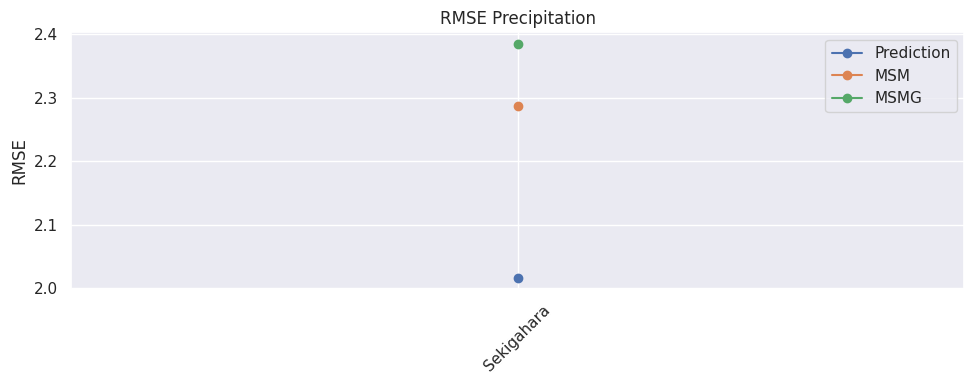

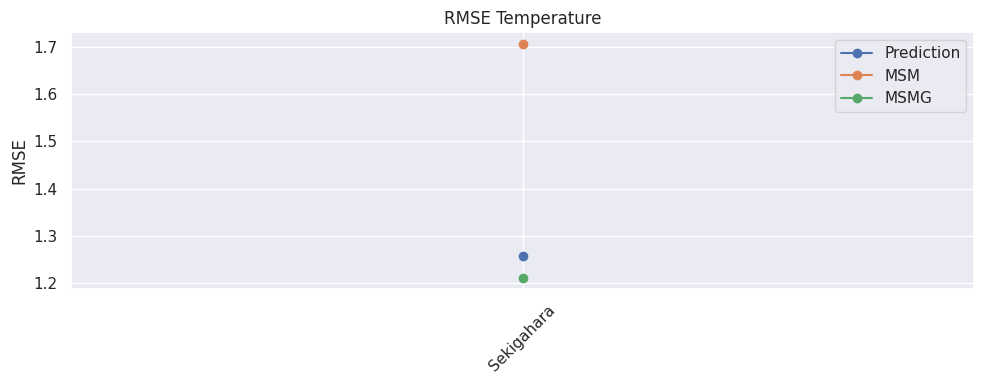

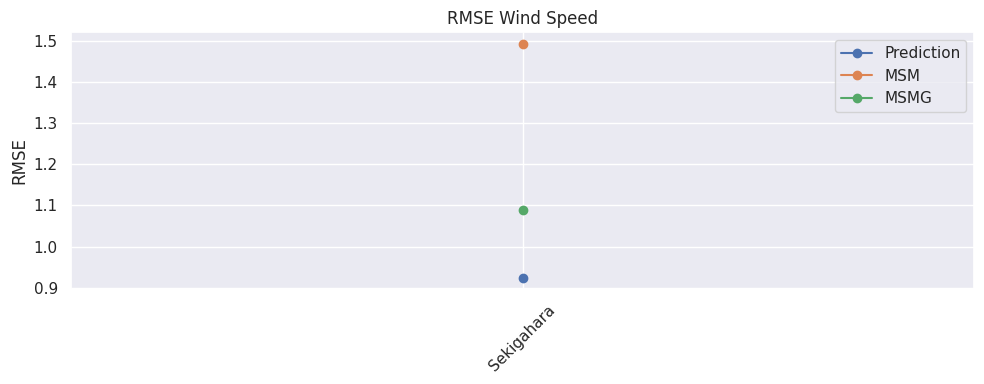

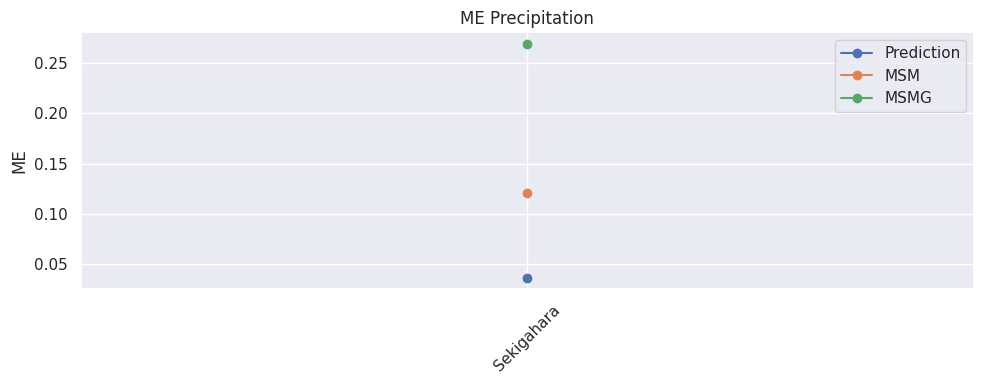

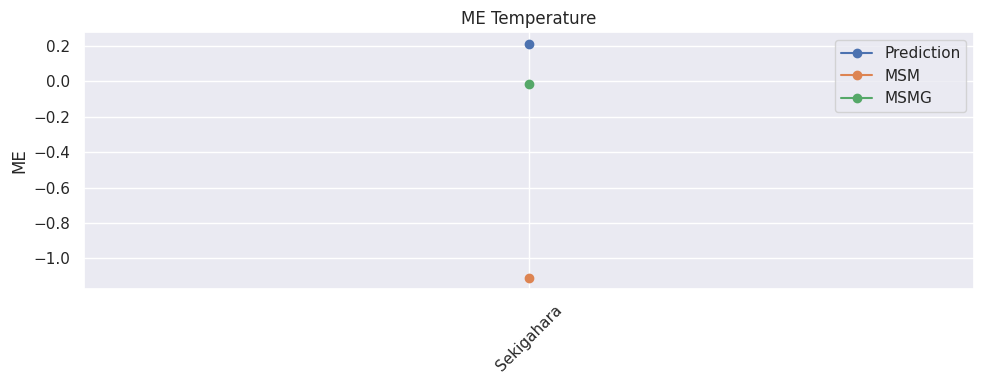

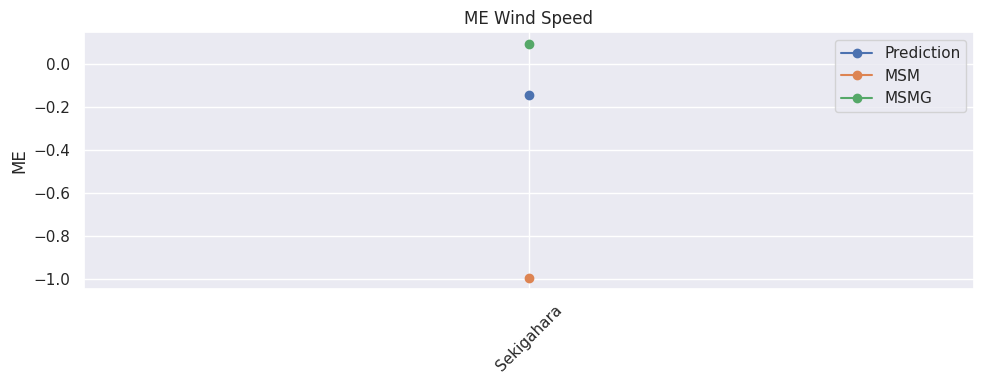

In [15]:
test_pred_list = test_pred_dict['around_all_tune']
comute_accuracy_pt(position_df.index, test_pred_list, test_msm_list, test_true_list, phase='test', pt='position', msmg_list=test_msmg_list)

Accuracy by lead time (test set): RMSE/ME for each forecast horizon

RMSE                                   ME              \
              Precipitation Temperature Wind Speed Precipitation Temperature   
3  MSM                1.879       1.589      1.465         0.146      -1.087   
   MSMG               2.090       1.056      1.026         0.295      -0.002   
   Prediction         1.861       1.115      0.889         0.046       0.232   
6  MSM                1.960       1.609      1.473         0.102      -1.086   
   MSMG               2.214       1.090      1.040         0.271       0.000   
   Prediction         1.886       1.154      0.897         0.043       0.226   
9  MSM                2.109       1.641      1.480         0.115      -1.099   
   MSMG               2.231       1.127      1.057         0.247      -0.008   
   Prediction         1.958       1.183      0.909         0.050       0.206   
12 MSM                2.211       1.665      1.484         0.123      -1.105   
   MSMG               2.395       1.160      1.065         0.263      -0.015   
   Prediction         2.016       1.197      0.906         0.063       0.209   
15 MSM                2.301       1.685      1.492         0.126      -1.113   
   MSMG               2.383       1.181      1.076         0.265      -0.019   
   Prediction         2.052       1.226      0.919         0.059       0.208   
18 MSM                2.457       1.703      1.479         0.108      -1.111   
   MSMG               2.441       1.205      1.079         0.236      -0.020   
   Prediction         2.088       1.247      0.918         0.037       0.194   
21 MSM                2.286       1.716      1.493         0.114      -1.115   
   MSMG               2.283       1.217      1.087         0.259      -0.020   
   Prediction         2.019       1.268      0.924         0.047       0.196   
24 MSM                2.314       1.727      1.504         0.144      -1.117   
   MSMG               2.343       1.230      1.095         0.283      -0.024   
   Prediction         2.031       1.266      0.931         0.046       0.207   
27 MSM                2.415       1.736      1.490         0.147      -1.116   
   MSMG               2.372       1.247      1.141         0.287      -0.020   
   Prediction         2.044       1.293      0.938         0.047       0.211   
30 MSM                2.466       1.752      1.494         0.102      -1.115   
   MSMG               2.474       1.275      1.122         0.253      -0.015   
   Prediction         2.021       1.322      0.938         0.013       0.216   
33 MSM                2.306       1.763      1.504         0.129      -1.118   
   MSMG               2.485       1.287      1.112         0.295      -0.019   
   Prediction         2.057       1.332      0.939         0.023       0.209   
36 MSM                2.530       1.776      1.518         0.124      -1.117   
   MSMG               2.646       1.308      1.121         0.284      -0.021   
   Prediction         2.070       1.344      0.952        -0.001       0.219   
39 MSM                2.408       1.799      1.519         0.090      -1.117   
   MSMG               2.589       1.341      1.117         0.260      -0.020   
   Prediction         2.101       1.374      0.963         0.002       0.216   

                          
              Wind Speed  
3  MSM            -0.997  
   MSMG            0.089  
   Prediction     -0.137  
6  MSM            -1.002  
   MSMG            0.085  
   Prediction     -0.151  
9  MSM            -0.997  
   MSMG            0.094  
   Prediction     -0.148  
12 MSM            -0.991  
   MSMG            0.097  
   Prediction     -0.141  
15 MSM            -0.994  
   MSMG            0.087  
   Prediction     -0.145  
18 MSM            -0.975  
   MSMG            0.116  
   Prediction     -0.127  
21 MSM            -0.987  
   MSMG            0.100  
   Prediction     -0.137  
24 MSM            -0.999  
   MSMG            0.078  
   Prediction     -0.142  
27 MSM            -0.976  
   MSMG      

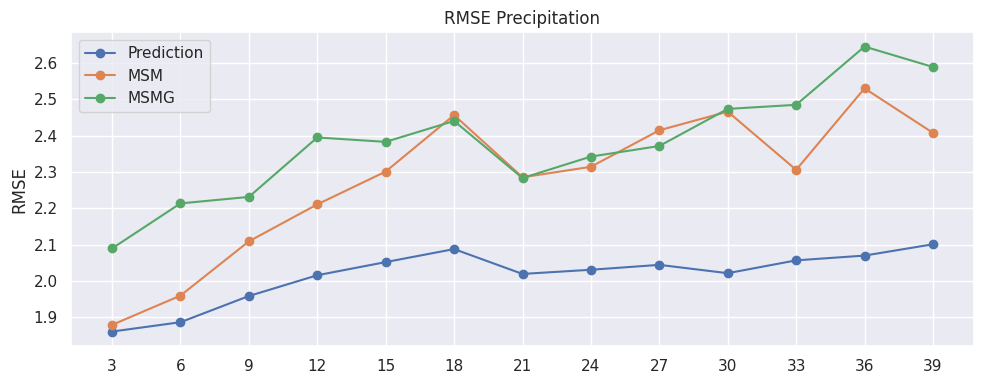

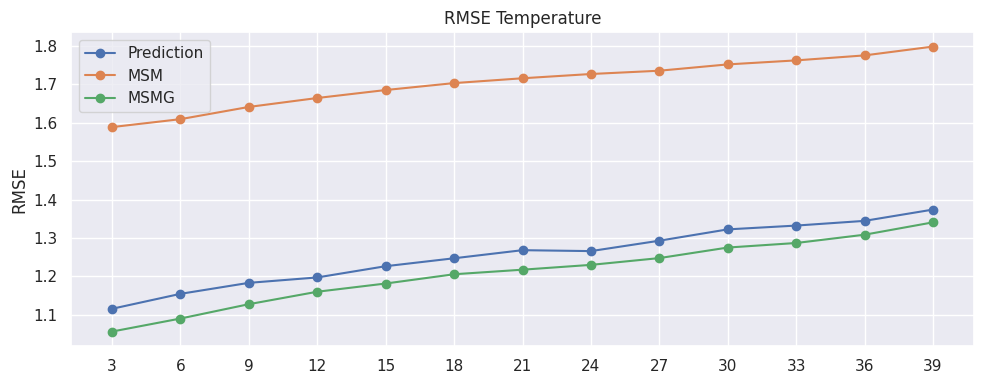

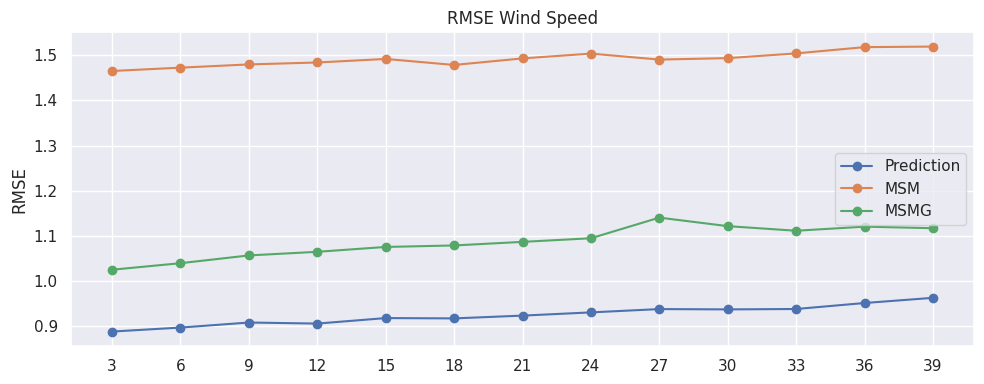

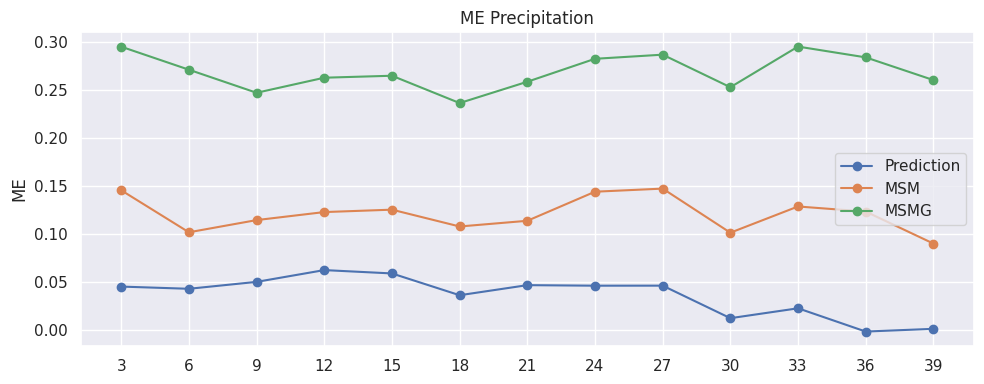

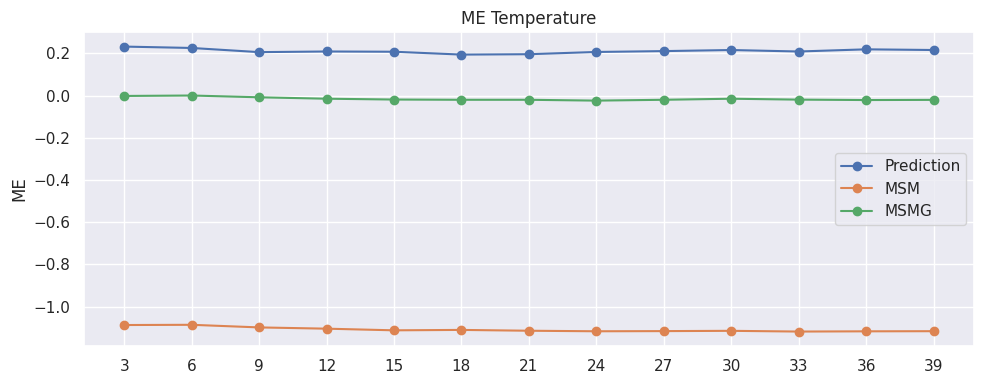

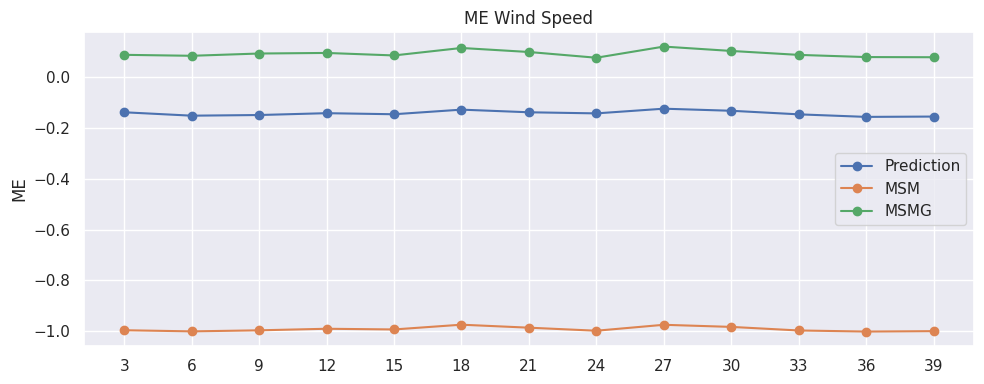

In [16]:
comute_accuracy_pt(timelist, test_pred_list, test_msm_list, test_true_list, phase='test', pt='time', msmg_list=test_msmg_list)

Plot time series

Number of samples in 2023-01: 244
y_true_jan.shape: (244, 3)
y_pred_jan.shape: (244, 3)


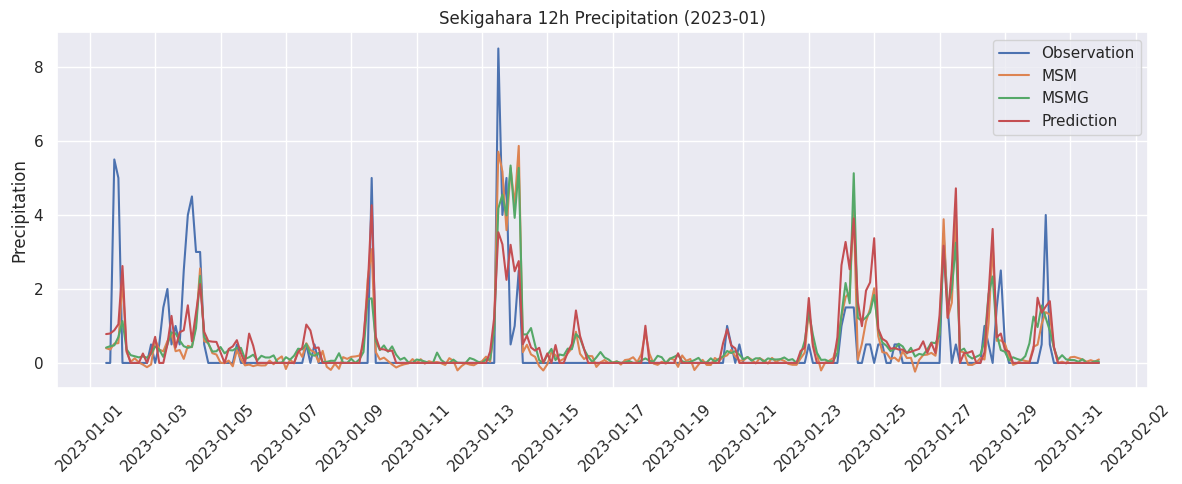

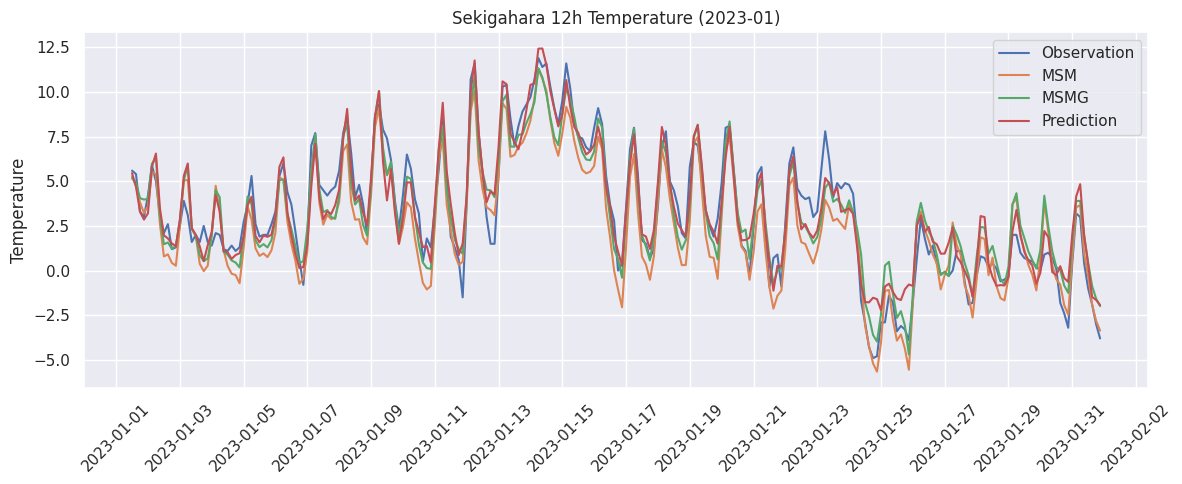

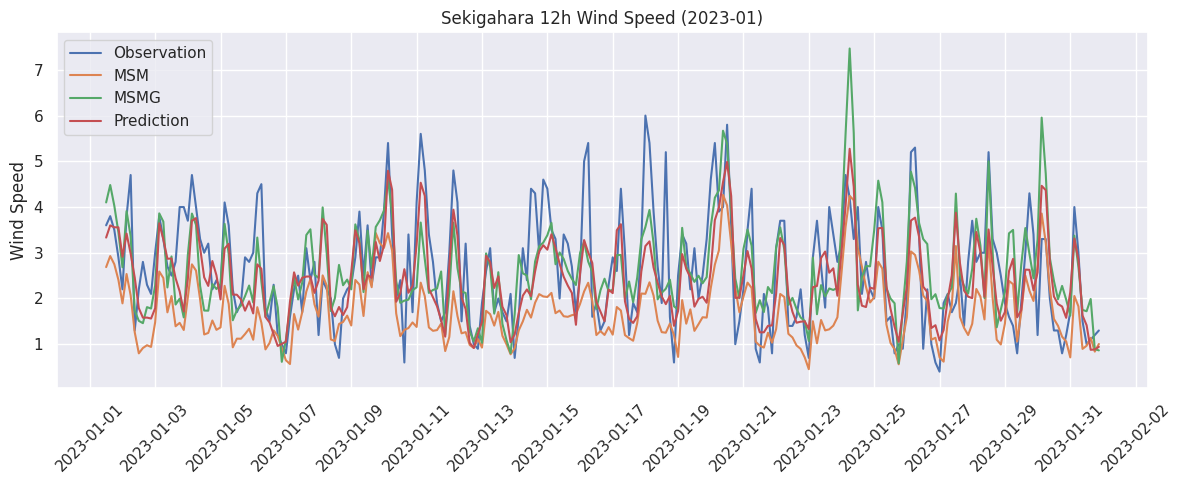

In [17]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Select one station and one lead time (example: Sekigahara, h=12)
pos_name = 'Sekigahara'
h = 12

# Map station name / lead time to indices in the nested [pos][h] lists
i = position_df.index.get_loc(pos_name)
j = timelist.index(h)

# Extract arrays for the chosen station & lead (test set)
y_pred_full = test_pred_dict['around_all_tune'][i][j]  # (N, 3) ndarray
y_msm_full  = test_msm_list[i][j]                      # (N, 3) ndarray
y_msmg_full = test_msmg_list[i][j]                     # (N, 3) ndarray
y_true_full = test_true_list[i][j]                     # (N, 3) DataFrame (with DatetimeIndex)

# Filter to a specific month (here: January 2023)
idx = y_true_full.index
mask_jan23 = (idx >= pd.Timestamp('2023-01-01 00:00')) & (idx < pd.Timestamp('2023-02-01 00:00'))
print("Number of samples in 2023-01:", mask_jan23.sum())

# Apply the same mask to all series and align indices
y_true_jan = y_true_full.loc[mask_jan23].copy()
cols = y_true_full.columns  # ['Precipitation', 'Temperature', 'Wind Speed']

# Convert ndarrays to DataFrames so everything shares the same index/columns
y_pred_jan = pd.DataFrame(y_pred_full[mask_jan23, :], index=y_true_jan.index, columns=cols)
y_msm_jan  = pd.DataFrame(y_msm_full[mask_jan23, :],  index=y_true_jan.index, columns=cols)
y_msmg_jan = pd.DataFrame(y_msmg_full[mask_jan23, :], index=y_true_jan.index, columns=cols)

print("y_true_jan.shape:", y_true_jan.shape)
print("y_pred_jan.shape:", y_pred_jan.shape)

# Plot time series
for c in ['Precipitation', 'Temperature', 'Wind Speed']:

    # Time series (Observation vs MSM/MSMG/Prediction)
    fig, ax = plt.subplots(figsize=(12, 5))
    ax.plot(y_true_jan.index, y_true_jan[c], label='Observation')
    ax.plot(y_msm_jan.index,  y_msm_jan[c],  label='MSM')
    ax.plot(y_msmg_jan.index, y_msmg_jan[c], label='MSMG')
    ax.plot(y_pred_jan.index, y_pred_jan[c], label='Prediction')

    ax.set_title(f'{pos_name} {h}h {c} (2023-01)')
    ax.set_ylabel(c)
    ax.legend()

    # Make the date axis readable
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


## Wilcoxon analisys

In [18]:
import numpy as np
import pandas as pd
from scipy.stats import ttest_rel, wilcoxon

# Shared config: variable order must match y_true columns
VAR_NAMES = ["Precipitation", "Temperature", "Wind Speed"]

def _as_2d(a):
    a = np.asarray(a)
    if a.ndim == 1:
        return a.reshape(-1, 1)
    return a

def _collect_abs_errors(
    main_list, base_list, true_list, var_idx,
    precip_round_thresh=None,
    apply_round_to_obs=False
):
    """
    Collect paired absolute errors for one variable across [pos][lead].
    If precip_round_thresh is set, values < thresh are rounded to 0 (precip only).
    """
    abs_main_all, abs_base_all = [], []

    npos = len(true_list)
    for i in range(npos):
        nlead = len(true_list[i])
        for j in range(nlead):
            y_true_df = true_list[i][j]
            if y_true_df is None:
                continue

            y_true = np.asarray(y_true_df.values, float)          # (T,3)
            y_main = np.asarray(main_list[i][j], float)           # (T,3)
            y_base = np.asarray(base_list[i][j], float)           # (T,3)

            # Use only timestamps where (true, main, base) are all non-NaN
            m = (
                ~np.isnan(y_true[:, var_idx]) &
                ~np.isnan(y_main[:, var_idx]) &
                ~np.isnan(y_base[:, var_idx])
            )
            if not np.any(m):
                continue

            yt = y_true[m, var_idx].copy()
            ym = y_main[m, var_idx].copy()
            yb = y_base[m, var_idx].copy()

            # Optional: precip rounding sensitivity
            if precip_round_thresh is not None:
                ym[ym < precip_round_thresh] = 0.0
                yb[yb < precip_round_thresh] = 0.0
                if apply_round_to_obs:
                    yt[yt < precip_round_thresh] = 0.0

            abs_main_all.append(np.abs(ym - yt))
            abs_base_all.append(np.abs(yb - yt))

    if len(abs_main_all) == 0:
        return np.array([], dtype=float), np.array([], dtype=float)

    abs_main = np.concatenate(abs_main_all)
    abs_base = np.concatenate(abs_base_all)
    return abs_main, abs_base

def _safe_wilcoxon(diff, alternative="less", zero_method="wilcox"):
    # Wilcoxon can fail with many zero-differences; return NaN on errors
    diff = np.asarray(diff, float)
    diff = diff[~np.isnan(diff)]
    if diff.size == 0:
        return np.nan
    try:
        return wilcoxon(diff, alternative=alternative, zero_method=zero_method).pvalue
    except Exception:
        return np.nan

def make_table7(
    main_pred, msm_base, msmg_base, true_list,
    zero_method="wilcox"
):
    """
    Table 7: compare main vs baseline (MSM / MSMG) using paired absolute errors.
    H1 for tests: main has smaller error than baseline.
    """
    rows = []
    N_used = None

    for var_idx, var in enumerate(VAR_NAMES):
        for base_name, base_list in [("MSM", msm_base), ("MSMG", msmg_base)]:
            abs_main, abs_base = _collect_abs_errors(main_pred, base_list, true_list, var_idx)

            N = abs_main.size
            if N_used is None:
                N_used = N

            mae_main = float(abs_main.mean()) if N else np.nan
            mae_base = float(abs_base.mean()) if N else np.nan

            diff = abs_main - abs_base
            sd_diff = float(np.std(diff, ddof=1)) if N > 1 else np.nan

            p_t = ttest_rel(abs_main, abs_base, alternative="less").pvalue if N > 1 else np.nan
            p_w = _safe_wilcoxon(diff, alternative="less", zero_method=zero_method)

            rows.append([var, base_name, mae_main, mae_base, sd_diff, p_t, p_w])

    df = pd.DataFrame(rows, columns=["Variable", "Baseline", "MAE_main", "MAE_base", "SD_diff", "p_t", "p_w"])
    return df, N_used

def make_table8_precip(
    main_pred, msm_base, msmg_base, true_list,
    thresh_list=(0.0, 0.5, 1.0),
    zero_method="wilcox",
    apply_round_to_obs=False
):
    """
    Table 8: precipitation-only sensitivity to rounding threshold.
    Apply the same rounding to model outputs (and optionally observations).
    """
    rows = []
    for thr in thresh_list:
        for base_name, base_list in [("MSM", msm_base), ("MSMG", msmg_base)]:
            abs_main, abs_base = _collect_abs_errors(
                main_pred, base_list, true_list, var_idx=0,
                precip_round_thresh=thr,
                apply_round_to_obs=apply_round_to_obs
            )

            N = abs_main.size
            mae_main = float(abs_main.mean()) if N else np.nan
            mae_base = float(abs_base.mean()) if N else np.nan
            diff = abs_main - abs_base
            p_w = _safe_wilcoxon(diff, alternative="less", zero_method=zero_method)

            rows.append([thr, base_name, mae_main, mae_base, p_w])

    df = pd.DataFrame(rows, columns=["thresh", "Baseline", "MAE_main", "MAE_base", "p_w"])
    return df


In [19]:
# --- compute_ypred WITHOUT precipitation thresholding ---
def compute_ypred_raw(y_all, predictions, mask, outcolumns):
    y_pred = np.full((len(y_all), len(outcolumns)), np.nan)
    y_pred[mask] = predictions
    return y_pred

# --- Recompute "around_all_tune" test predictions WITHOUT rounding (no retraining) ---

xy = get_xy_train_validation_test(outcolumns, train_combined_df, validation_combined_df, test_hlist, grids="around")

models = val_pred["model_list"]  # already-trained models (one per target variable)
raw_hlist = []
for j, h in enumerate(timelist):
    x_test = xy["x_test_all_list"][j]
    y_test = xy["y_test_all_list"][j]
    m = xy["test_mask_list"][j]

    # Predict only on valid rows, then put results back into the full (T,3) shape with NaNs elsewhere
    pred = np.vstack([models[k].predict(x_test[m]) for k in range(3)]).T  # (n_valid, 3)
    raw_hlist.append(compute_ypred_raw(y_test, pred, m, outcolumns))

# Store in the same structure as test_pred_dict: [pos][lead]
test_pred_dict_raw = {"around_all_tune": [[] for _ in range(len(position_df.index))]}
i = position_df.index.get_loc(pos)
test_pred_dict_raw["around_all_tune"][i] = raw_hlist

# Quick check: fraction of exactly-zero precipitation predictions (should typically decrease without rounding)
pred_raw = np.array(test_pred_dict_raw["around_all_tune"]).reshape(-1, 3)[:, 0]
print("min raw pred precip:", np.nanmin(pred_raw), " frac(raw==0):", np.nanmean(pred_raw == 0))


min raw pred precip: -0.0775777793166035  frac(raw==0): 0.0


In [22]:
from IPython.display import display, Markdown

main_thr  = test_pred_dict["around_all_tune"]       # thresholding: precip < 0.25 -> 0.0

# ===== choose which one to evaluate =====
USE_RAW = False  # True: raw, False: thresholded

main_pred  = main_raw if USE_RAW else main_thr
main_title = "RAW (no precipitation thresholding)" if USE_RAW else "THRESHOLDED (precip < 0.25 -> 0.0)"

# ===== Table 7 in the paper=====
display(Markdown(f"### Table 7 — Main prediction: **{main_title}**"))

tab7, N = make_table7(
    main_pred=main_pred,
    msm_base=test_msm_list,
    msmg_base=test_msmg_list,
    true_list=test_true_list,
    zero_method="wilcox",
)

display(tab7)
print("N =", N)


### Table 7 — Main prediction: **THRESHOLDED (precip < 0.25 -> 0.0)**

,Variable,Baseline,MAE_main,MAE_base,SD_diff,p_t,p_w
0,Precipitation,MSM,0.592711,0.673003,1.116309,8.292307e-45,0.0
1,Precipitation,MSMG,0.592711,0.722229,1.416487,5.262313e-71,0.0
2,Temperature,MSM,0.962850,1.413757,1.149985,0.000000e+00,0.0
3,Temperature,MSMG,0.962850,0.930453,0.700684,1.000000e+00,1.0
4,Wind Speed,MSM,0.709879,1.189847,0.790137,0.000000e+00,0.0
5,Wind Speed,MSMG,0.709879,0.841483,0.567126,0.000000e+00,0.0


N = 37960


In [23]:
from IPython.display import display, Markdown


# ===== Table 8 in the paper=====
display(Markdown(f"### Table 8 — Precipitation rounding sensitivity (Main prediction: **{main_title}**)"))

tab8 = make_table8_precip(
    main_pred=main_pred,
    msm_base=test_msm_list,
    msmg_base=test_msmg_list,
    true_list=test_true_list,
    thresh_list=(0.0, 0.5, 1.0),
    zero_method="wilcox",
    apply_round_to_obs=False
)
display(tab8)


### Table 8 — Precipitation rounding sensitivity (Main prediction: **THRESHOLDED (precip < 0.25 -> 0.0)**)

,thresh,Baseline,MAE_main,MAE_base,p_w
0,0.0,MSM,0.592711,0.660949,1.185581e-235
1,0.0,MSMG,0.592711,0.722229,0.000000e+00
2,0.5,MSM,0.563047,0.587592,1.000000e+00
3,0.5,MSMG,0.563047,0.623238,9.988737e-01
4,1.0,MSM,0.531105,0.575110,9.433605e-01
5,1.0,MSMG,0.531105,0.599886,4.461990e-04
